In [57]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad
import cv2
# import scanorama
from sklearn.model_selection import train_test_split

In [58]:
# Import spatial omics library
#import athena as ath
from spatialOmics import SpatialOmics

# import default graph builder parameters
#from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

In [59]:
# Check pytorch
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


True
0
1
NVIDIA RTX A2000 12GB


In [60]:
import torch_geometric.utils

p_dir = 'Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline'
#spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph_external'
spatial_omics_folder = p_dir + '\\Data' + '\\spatial_omics_graph_external'
#process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'
process_path = p_dir + '\\Data' + '\\torch_graph_data'

In [61]:
from torch_geometric.transforms import LocalCartesian, Cartesian, Polar

# Breast Cancer

In [201]:
### Read clinical data
path = r'Y:\coskun-lab\Thomas\graph\Breast IMC 2\clinical data\41586_2019_1007_MOESM7_ESM.txt'
df_info = pd.read_csv(path , sep="\t")

In [202]:
df_info.columns

Index(['METABRIC.ID', 'MATCHED.NORMAL.METABRIC.ID', 'Cohort',
       'Age.At.Diagnosis', 'Breast.Tumour.Laterality', 'Date.Of.Diagnosis',
       'Last.Followup.Status', 'NPI', 'ER.Status', 'Inferred.Menopausal.State',
       'Lymph.Nodes.Positive', 'Breast.Surgery', 'CT', 'HT', 'RT', 'Grade',
       'Size', 'Histological.Type', 'Stage', 'DeathBreast', 'Death', 'T',
       'TLR', 'LR', 'TDR', 'DR', 'Complete.Rec.History'],
      dtype='object')

In [203]:
# Generate spatial omics dataframe
data_name = 'Breast_IMC_2'
spatial_path = spatial_omics_folder + '\\' + f'{data_name}.hdf5'
spadata = SpatialOmics.from_h5py(spatial_path)


In [204]:
spadata.obs['1']

metabricId  core_id  ImageNumber  ObjectNumber  Location_Center_X  \
1       MB-0901        1            1             1           49.00000   
2       MB-0901        1            1             2          345.00000   
3       MB-0901        1            1             3           29.50000   
4       MB-0901        1            1             4          291.19232   
5       MB-0901        1            1             5          261.25372   
...         ...      ...          ...           ...                ...   
1661    MB-0901        1            1          1661          383.96490   
1662    MB-0901        1            1          1662          304.67499   
1663    MB-0901        1            1          1663          404.26251   
1664    MB-0901        1            1          1664          464.86957   
1665    MB-0901        1            1          1665          394.48572   

      Location_Center_Y  SOM_nodes  pg_cluster               description  \
1              1.052632         71          16                     HER2+   
2              3.923077         37          18            HR- CKlow CK5+   
3              5.000000         18           8         Fibroblasts CD68+   
4              4.884615         15          47  Macrophages Vim+ CD45low   
5              4.298508        122          19    Macrophages Vim+ Slug+   
...                 ...        ...         ...                       ...   
1661         502.807010          1          13    Macrophages Vim+ Slug-   
1662         502.725010         15          47  Macrophages Vim+ CD45low   
1663         501.799990         30          23             Myoepithelial   
1664         502.521730          2          13    Macrophages Vim+ Slug-   
1665         502.485720         30          23             Myoepithelial   

     meta_id           y           x  
1          5    1.052632   49.000000  
2         11    3.923077  345.000000  
3          4    5.000000   29.500000  
4         15    4.884615  291.192308  
5         16    4.298507  261.253731  
...      ...         ...         ...  
1661      17  502.807018  383.964912  
1662      15  502.725000  304.675000  
1663      18  501.800000  404.262500  
1664      17  502.521739  464.869565  
1665      18  502.485714  394.485714  

[1625 rows x 12 columns]

In [11]:
identifier = 'ImageNumber'

status = 'ER.Status'
grade = 'Grade'
stage = 'Stage'

In [12]:
er_dict = {'pos':1, 'neg':0}

In [11]:
# Create csv for all graph info
save_path = process_path / 'Breast' 
pt_path = save_path / 'pt'
pt_path.mkdir(parents=True, exist_ok=True)

# Create csv for all graph info
csv_path = save_path / 'info.csv'

data_names = []
foll_ids = []
paths = []

# Loop
for id in spadata.spl[identifier]:
    l = len(spadata.X[str(id)])
    meta_id = spadata.obs[str(id)].iloc[0].metabricId
    df_id = df_info[df_info['METABRIC.ID'] == spadata.obs[str(id)].iloc[0].metabricId]
    try:
        er = df_id[status].item()
        er_label = er_dict[er]
    except:continue

    # Generate torch data
    G = spadata.G[str(id)]['contact']
    pos = spadata.obs[str(id)][['x','y']].loc[np.array(G.nodes())].to_numpy()
    classes = spadata.obs[str(id)].description.to_numpy()

    df_int = spadata.X[str(id)]
    X = df_int.loc[np.array(G.nodes)].values
    
    data = torch_geometric.utils.from_networkx(spadata.G[str(id)]['contact'])
    data.x = torch.tensor(X).float()
    data.pos = torch.tensor(pos).float()
    data.node_types = classes

    data.label = torch.tensor(er_label)
    data.stage = torch.tensor(df_id[stage].item())
    data.grade = torch.tensor(df_id[grade].item())
    
    # Polar transform to be added to the data
    pos_transform = Polar()
    data  = pos_transform(data)
    
     # Save data and info
    path = save_path / 'pt' / f'{meta_id}_{id}.pt'
    torch.save(data, path)
    data_names.append(meta_id)
    foll_ids.append(id)
    paths.append(path)
df_info = pd.DataFrame({'Dataset': data_names, 'Foll': foll_ids, 'Path': paths,})
df_info.to_csv(csv_path)

In [12]:
df_info['fileName'] = df_info['Path'].map(lambda x: str(x).split('\\')[-1])

In [13]:
df_info.to_csv(csv_path)

# TLS

In [362]:
import pandas as pd

# Step 1: Load the Excel files
df_cells = pd.read_csv(r'Y:\coskun-lab\Efe and Nishkala\SnowflakePipeline\Data\Datasets\tls_colon_codex\CRC_clusters_neighborhoods_markers.csv')
df_patients = pd.read_excel(r'Y:\coskun-lab\Efe and Nishkala\SnowflakePipeline\Data\Datasets\tls_colon_codex\CRC_TMAs_patient_annotations.xlsx')
df_regions = pd.read_excel(r'Y:\coskun-lab\Efe and Nishkala\SnowflakePipeline\Data\Datasets\tls_colon_codex\Multi-tumor_TMA_composition.xlsx')

df_cells = df_cells[df_cells['groups'] == 1]
#df_cells = df_cells[df_cells['TMA_AB'] == 'A']

df_patients = df_patients.rename(columns={'Patient': 'patients'})
df_final = df_cells.merge(df_patients[['patients', 'OS']], on='patients', how='left')

# Step 5: Select and Rearrange Columns
rename_mapping = {
    'CellID': 'CellID',
    'File Name': 'FileName',
    'Region': 'Region',
    'groups': 'Groups',
    'patients': 'Patients',
    'OS': 'OS',
    'X:X': 'X',
    'Y:Y': 'Y',
    'Z:Z': 'Z',
    'CD20 - B cells:Cyc_8_ch_3': 'CD20',
    'CD4 - T helper cells:Cyc_6_ch_3': 'CD4',
    'CD21 - DCs:Cyc_6_ch_4': 'CD21',
    'Ki67 - proliferation:Cyc_5_ch_4': 'Ki67',
    'CD8 - cytotoxic T cells:Cyc_3_ch_2': 'CD8',
    'CD44 - stroma:Cyc_2_ch_2': 'CD44',
    'FOXP3 - regulatory T cells:Cyc_2_ch_3': 'FOXP3',
    'p53 - tumor suppressor:Cyc_3_ch_3': 'p53',
    'GATA3 - Th2 helper T cells:Cyc_3_ch_4': 'GATA3',
    'CD45 - hematopoietic cells:Cyc_4_ch_2': 'CD45',
    'T-bet - Th1 cells:Cyc_4_ch_3': 'Tbet',
    'beta-catenin - Wnt signaling:Cyc_4_ch_4': 'beta_catenin',
    'HLA-DR - MHC-II:Cyc_5_ch_2': 'HLA_DR',
    'PD-L1 - checkpoint:Cyc_5_ch_3': 'PD_L1',
    'CD45RA - naive T cells:Cyc_6_ch_2': 'CD45RA',
    'MUC-1 - epithelia:Cyc_7_ch_2': 'MUC1',
    'CD30 - costimulator:Cyc_7_ch_3': 'CD30',
    'CD2 - T cells:Cyc_7_ch_4': 'CD2',
    'Vimentin - cytoplasm:Cyc_8_ch_2': 'Vimentin',
    'LAG-3 - checkpoint:Cyc_8_ch_4': 'LAG_3',
    'Na-K-ATPase - membranes:Cyc_9_ch_2': 'Na_K_ATPase',
    'CD5 - T cells:Cyc_9_ch_3': 'CD5',
    'IDO-1 - metabolism:Cyc_9_ch_4': 'IDO_1',
    'Cytokeratin - epithelia:Cyc_10_ch_2': 'Cytokeratin',
    'CD11b - macrophages:Cyc_10_ch_3': 'CD11b',
    'CD56 - NK cells:Cyc_10_ch_4': 'CD56',
    'aSMA - smooth muscle:Cyc_11_ch_2': 'aSMA',
    'BCL-2 - apoptosis:Cyc_11_ch_3': 'BCL_2',
    'CD25 - IL-2 Ra:Cyc_11_ch_4': 'CD25',
    'CD11c - DCs:Cyc_12_ch_3': 'CD11c',
    'PD-1 - checkpoint:Cyc_12_ch_4': 'PD_1',
    'Granzyme B - cytotoxicity:Cyc_13_ch_2': 'Granzyme_B',
    'EGFR - signaling:Cyc_13_ch_3': 'EGFR',
    'VISTA - costimulator:Cyc_13_ch_4': 'VISTA',
    'CD15 - granulocytes:Cyc_14_ch_2': 'CD15',
    'ICOS - costimulator:Cyc_14_ch_4': 'ICOS',
    'Synaptophysin - neuroendocrine:Cyc_15_ch_3': 'Synaptophysin',
    'GFAP - nerves:Cyc_16_ch_2': 'GFAP',
    'CD7 - T cells:Cyc_16_ch_3': 'CD7',
    'CD3 - T cells:Cyc_16_ch_4': 'CD3',
    'Chromogranin A - neuroendocrine:Cyc_17_ch_2': 'Chromogranin_A',
    'CD163 - macrophages:Cyc_17_ch_3': 'CD163',
    'CD45RO - memory cells:Cyc_18_ch_3': 'CD45RO',
    'CD68 - macrophages:Cyc_18_ch_4': 'CD68',
    'CD31 - vasculature:Cyc_19_ch_3': 'CD31',
    'Podoplanin - lymphatics:Cyc_19_ch_4': 'Podoplanin',
    'CD34 - vasculature:Cyc_20_ch_3': 'CD34',
    'CD38 - multifunctional:Cyc_20_ch_4': 'CD38',
    'CD138 - plasma cells:Cyc_21_ch_3': 'CD138',
    'HOECHST1:Cyc_1_ch_1': 'HOECHST1',
    'CDX2 - intestinal epithelia:Cyc_2_ch_4': 'CDX2',
    'Collagen IV - bas. memb.:Cyc_12_ch_2': 'Collagen_IV',
    'CD194 - CCR4 chemokine R:Cyc_14_ch_3': 'CD194',
    'MMP9 - matrix metalloproteinase:Cyc_15_ch_2': 'MMP9',
    'CD71 - transferrin R:Cyc_15_ch_4': 'CD71',
    'CD57 - NK cells:Cyc_17_ch_4': 'CD57',
    'MMP12 - matrix metalloproteinase:Cyc_21_ch_4': 'MMP12',
    'DRAQ5:Cyc_23_ch_4': 'DRAQ5'
}

df_final = df_final[rename_mapping.keys()].rename(columns=rename_mapping)

# Add a new column 'OS_Less_Than_47' based on the OS value
df_final['OSLabel'] = df_final['OS'].apply(lambda x: 1 if x < 47 else 0)

# Display the first few rows of the updated dataframe
df_final.head()

C:\Users\eozturk7\AppData\Local\miniconda3\envs\torch_gpu2\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


CellID  FileName  Region  Groups  Patients         OS    X    Y   Z  \
0       0  reg001_A  reg001       1         1  71.334648   77  589  10   
1       1  reg001_A  reg001       1         1  71.334648  106  826  10   
2       2  reg001_A  reg001       1         1  71.334648  107  545  10   
3       3  reg001_A  reg001       1         1  71.334648   98  564  10   
4       4  reg001_A  reg001       1         1  71.334648  217  329  10   

       CD20  ...     HOECHST1        CDX2  Collagen_IV        CD194  \
0  0.000000  ...   472.335785   74.711678     0.000000   561.302551   
1  0.000000  ...   761.088501   48.307091     1.007260   252.166397   
2  0.000000  ...  1353.695679   74.369652     9.413397   341.091827   
3  0.005464  ...   844.661743   38.616947     0.000000   887.135681   
4  0.000000  ...  1746.380859  269.153992     0.000000  2924.110596   

        MMP9         CD71        CD57       MMP12        DRAQ5  OSLabel  
0   0.000000   655.881592   27.169783   36.131023  2011.402222        0  
1   0.000000   478.416260  160.619858   39.138241  3221.254883        0  
2  17.974144   387.765259   72.910377    2.523008  5228.323730        0  
3   0.000000   612.506958   12.255139   30.254667  1259.016846        0  
4   0.000000  2661.427979   84.200500  186.074799  8041.375000        0  

[5 rows x 68 columns]

In [284]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from pathlib import Path
from scipy.stats import zscore

# Assuming your dataframe is named df_final
identifier = 'Region'  # or 'CellID' if you want to group by individual cells
status_column = 'OSLabel'  # This should be the column with 0 and 1 values

save_path = Path(process_path + '\\TLS_efe5')  # Update the path as needed
save_path.mkdir(parents=True, exist_ok=True)

data_names = []
paths = []

# Columns to drop (excluding X and Y)
columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'Z', status_column]

# Loop through each unique identifier
for id in df_final[identifier].unique():
    df_sub = df_final[df_final[identifier] == id]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Create a graph G using NetworkX
    G = nx.Graph()

    # Add nodes with feature data and positional information
    for index, row in df_sub.iterrows():
        node_id = row.name  # Use the index as node_id
        G.add_node(node_id, x=row.drop(['X', 'Y']).values.astype(float), pos=row[['X', 'Y']].values.astype(float))

    # Optionally, add edges based on proximity or other criteria
    for node1, data1 in G.nodes(data=True):
        for node2, data2 in G.nodes(data=True):
            if node1 != node2:
                # Add edges based on a distance threshold using the positional information
                distance = np.linalg.norm(data1['pos'] - data2['pos'])
                if distance < 25:  # Example threshold
                    G.add_edge(node1, node2)

    # Convert to torch geometric data
    data = from_networkx(G)
    data.x = torch.tensor([data['x'] for _, data in G.nodes(data=True)]).float()
    data.pos = torch.tensor([data['pos'] for _, data in G.nodes(data=True)]).float()
    
    # Assign the label for the entire graph based on the status of the first row in the original subset
    graph_label = df_final[df_final[identifier] == id].iloc[0][status_column]
    data.y = torch.tensor([graph_label]).long()  # Graph-level label
    
    # Optionally, apply additional transforms like Polar if needed
    pos_transform = Polar()  # Uncomment if using a custom Polar transform
    data = pos_transform(data)

    # Save the graph data
    meta_id = f'{id}'
    path = save_path / f'{meta_id}.pt'
    torch.save(data, path)
    data_names.append(meta_id)
    paths.append(path)

# Save all information to a CSV
df_info = pd.DataFrame({'Dataset': data_names, 'Path': paths})
csv_path = save_path / 'info.csv'
df_info.to_csv(csv_path, index=False)


KeyboardInterrupt: 

In [ ]:
#graphs on follicles (cd20 high)

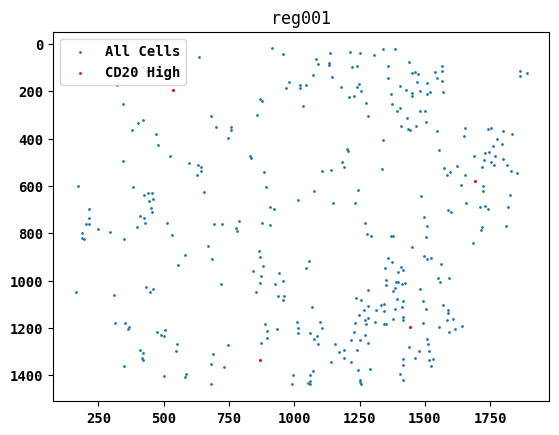

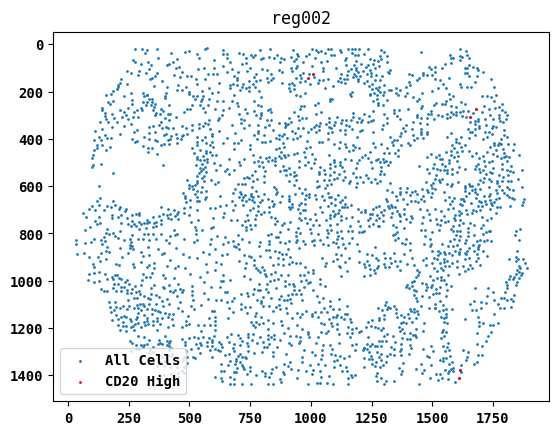

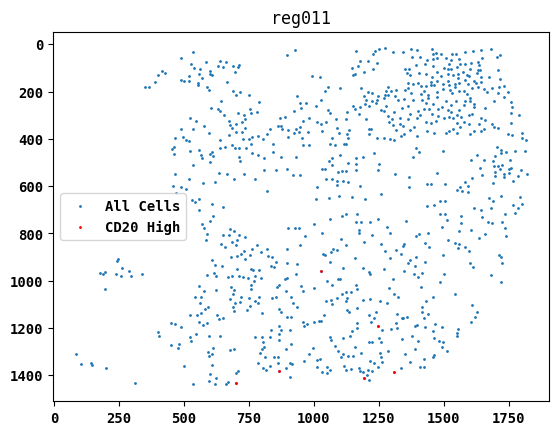

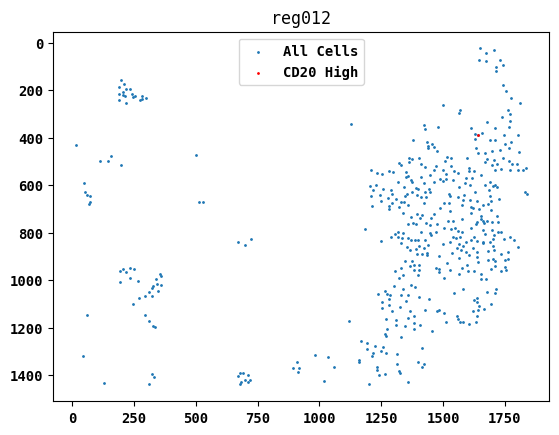

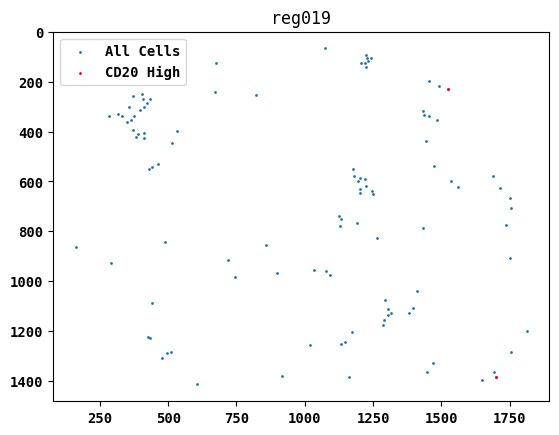

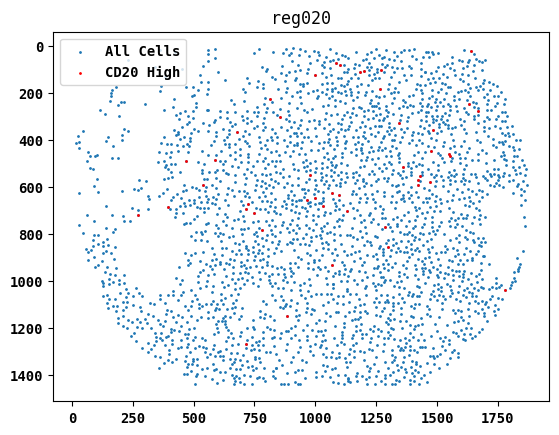

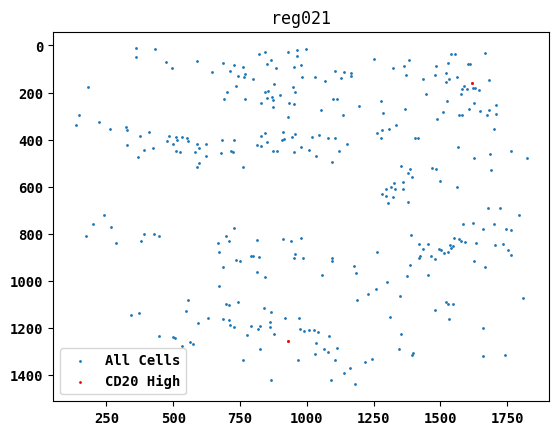

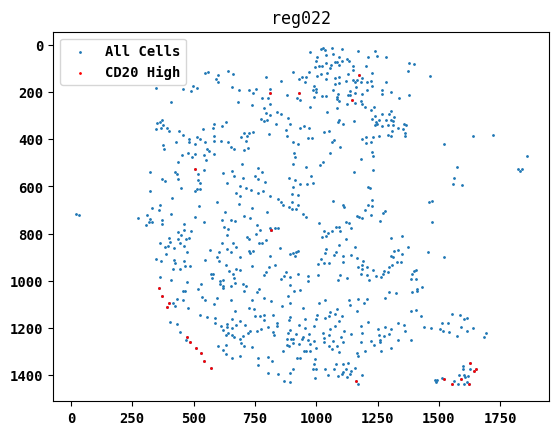

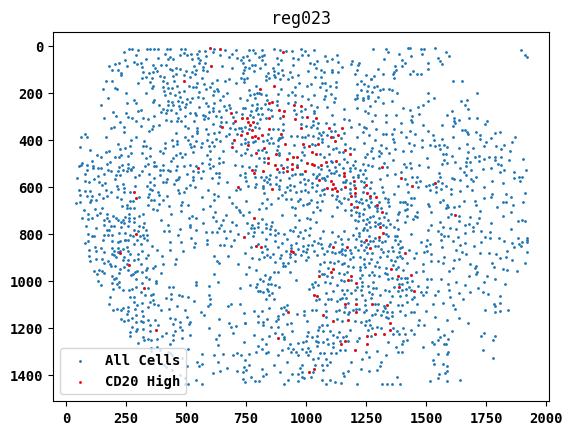

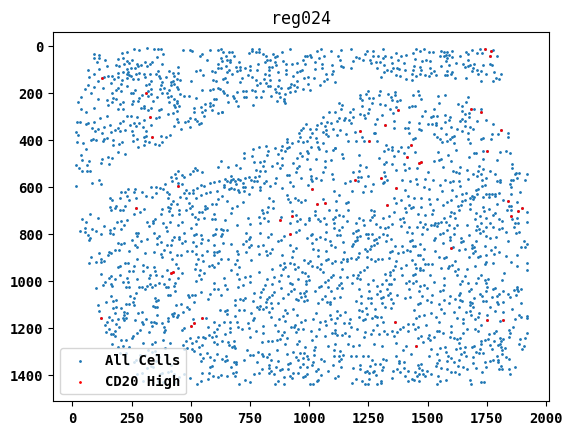

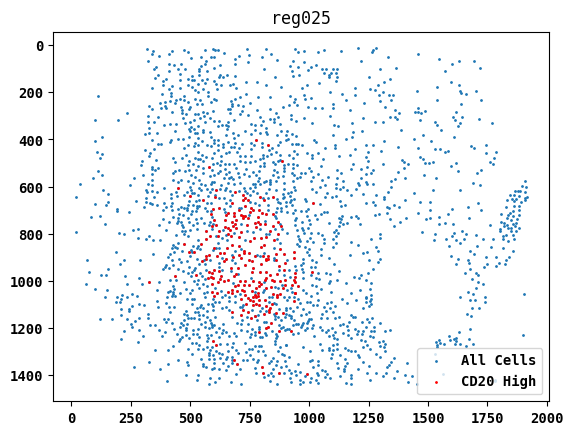

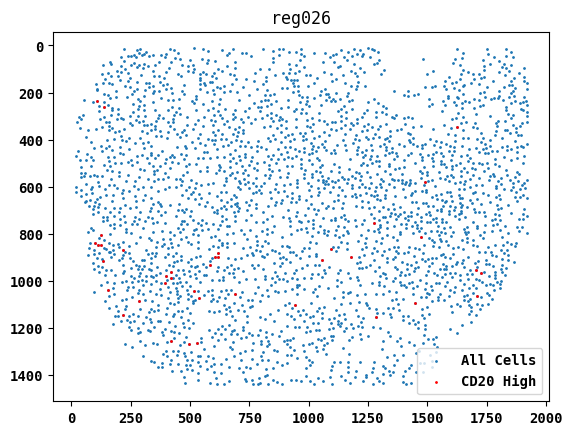

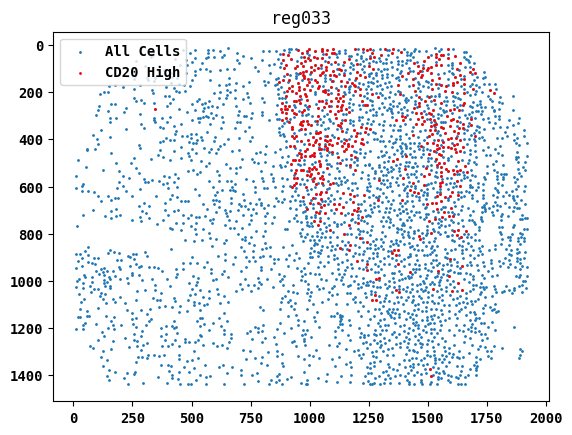

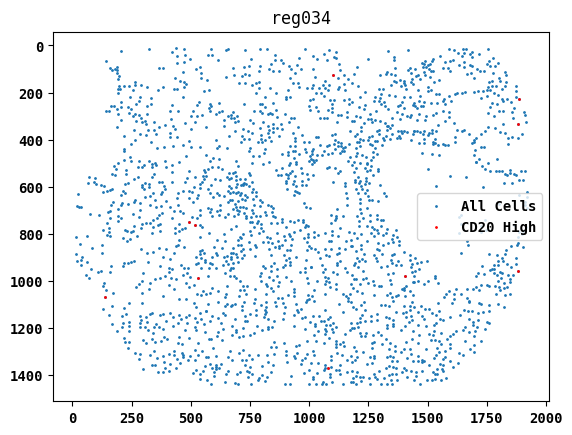

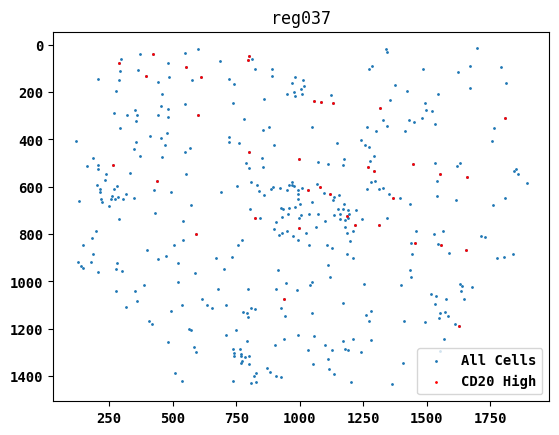

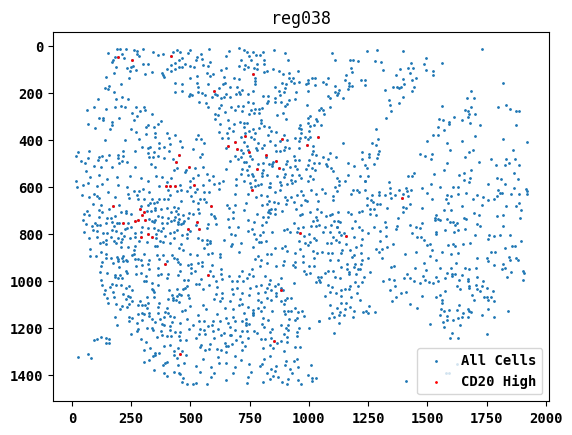

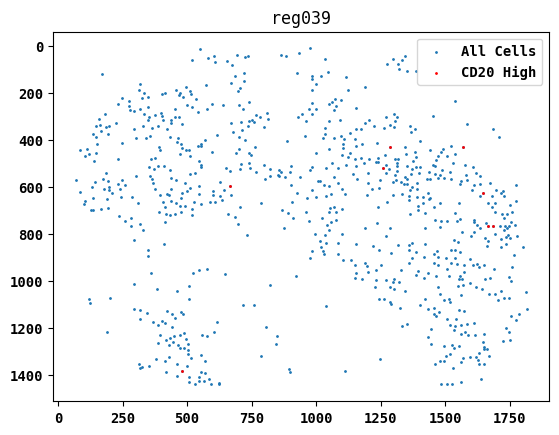

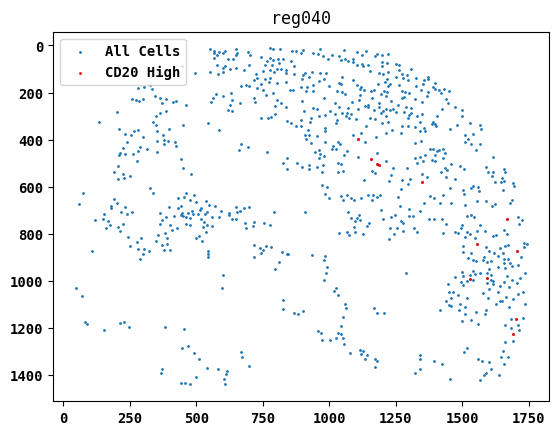

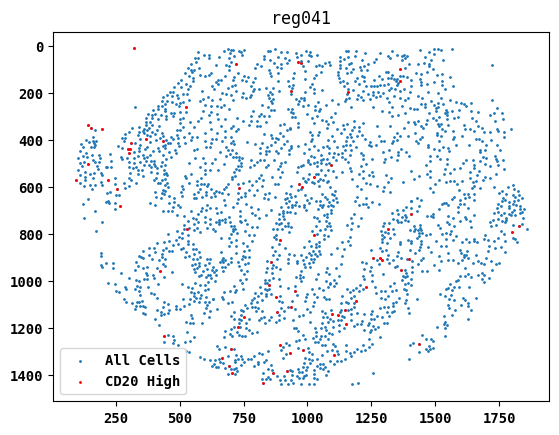

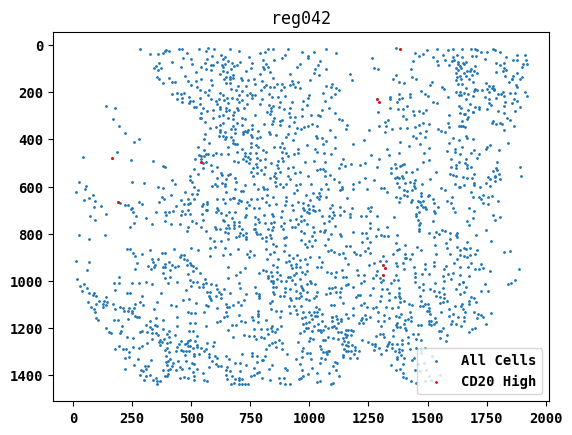

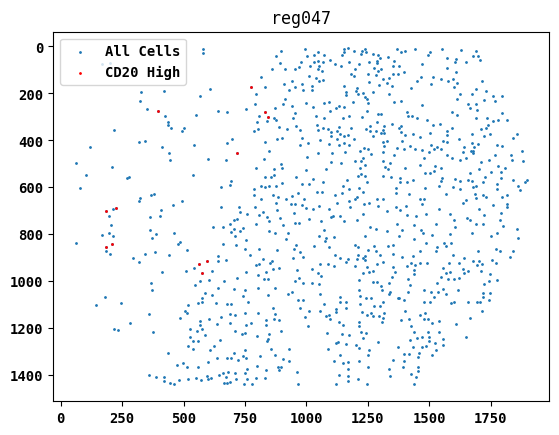

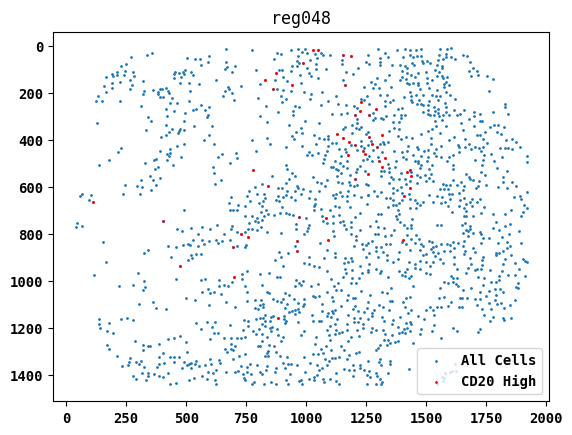

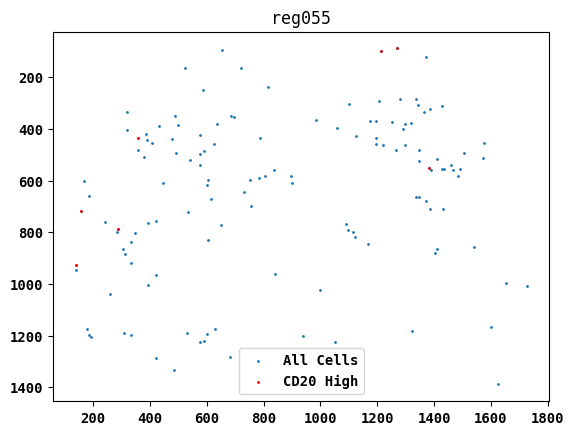

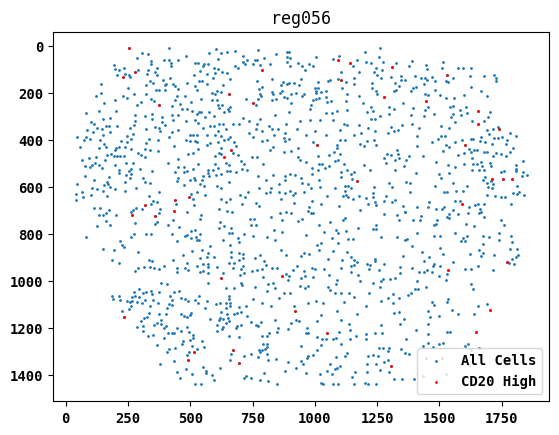

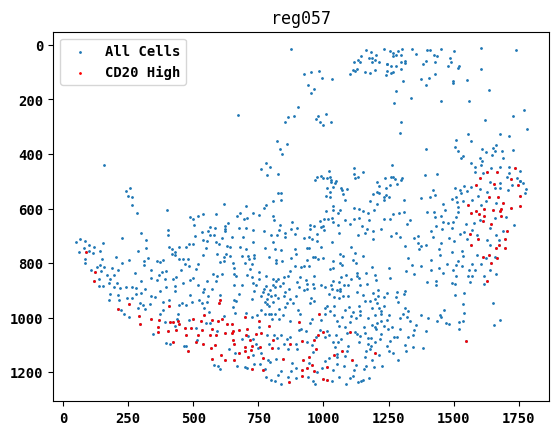

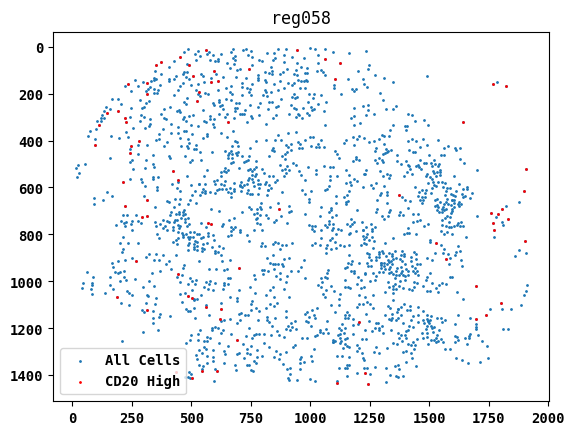

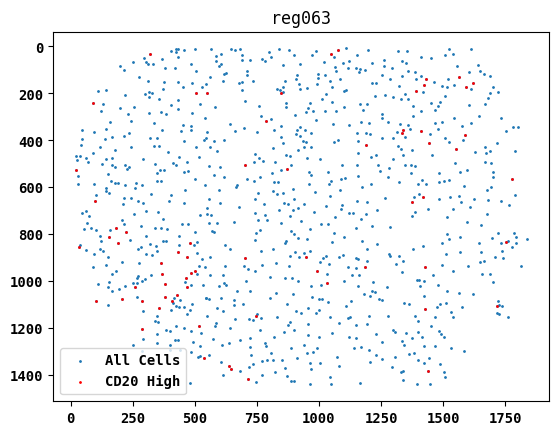

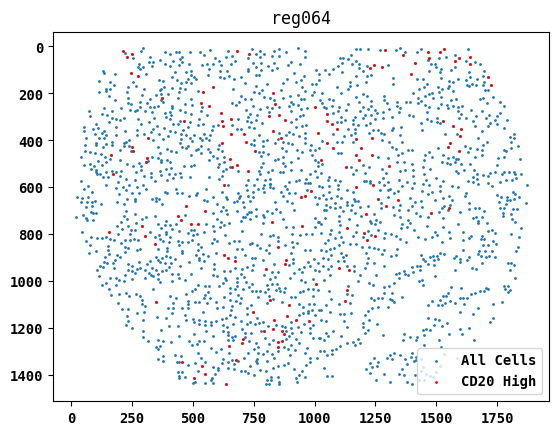

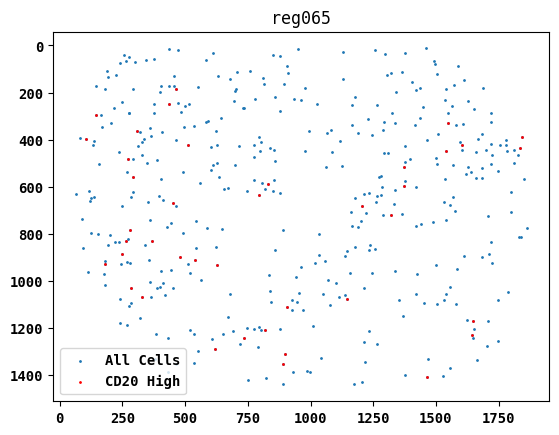

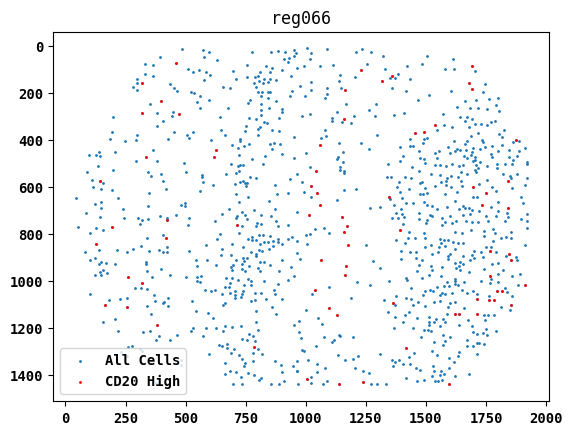

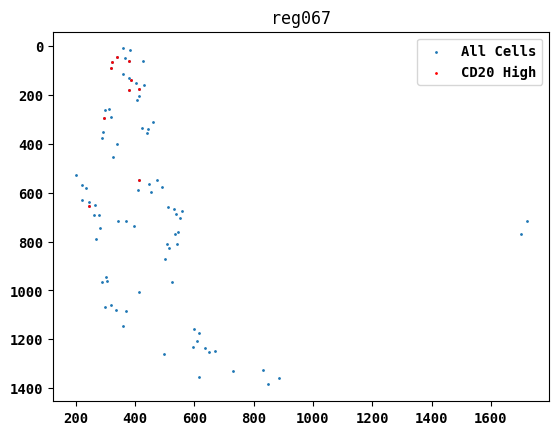

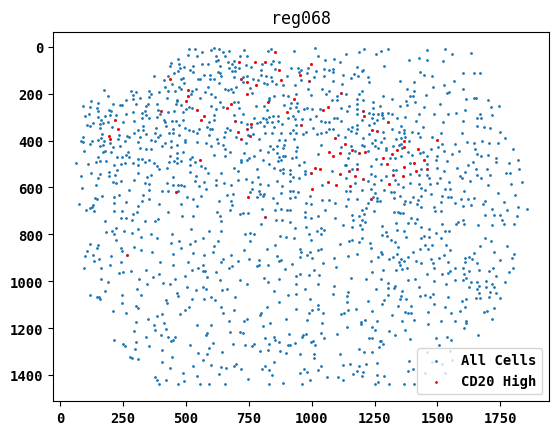

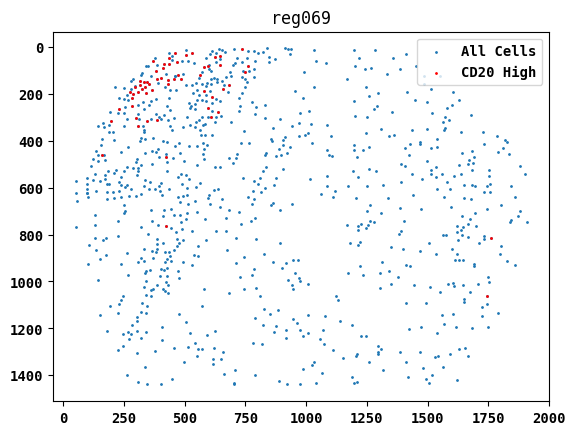

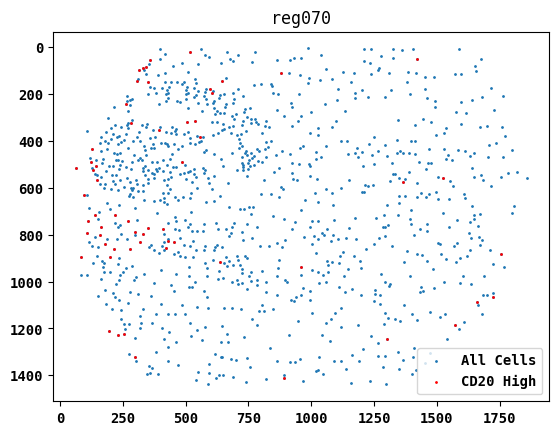

In [357]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

for region in np.unique(df_final['Region']):
    # Assuming your dataframe is named df_final
    identifier = 'Region'  # or 'CellID' if you want to group by individual cells
    
    # Select the region or identifier you want to visualize
    selected_region = region  # Example identifier
    
    # Filter the dataframe for the selected region
    df_sub = df_final[df_final[identifier] == selected_region]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Columns to drop (excluding X, Y)
    columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'Z']
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Adaptive thresholding based on CD20 intensity after Z-score normalization
    cd20_normalized = df_sub['CD20']
    #cd20_threshold = np.percentile(cd20_normalized, 95)  # Example: 95th percentile
    cd20_threshold = cd20_normalized.mean()+cd20_normalized.std()
    cd20_high = cd20_normalized > cd20_threshold
    
    # Separate CD20 high-intensity cells
    high_cells = df_sub[cd20_high]
    high_positions = positions[cd20_high]
    
    # Create a graph G using NetworkX for all cells
    G = nx.Graph()
    
    # Add nodes with feature data and positional information
    for index, row in df_sub.iterrows():
        node_id = row.name  # Use the index as node_id
        G.add_node(node_id, x=row.drop(['X', 'Y']).values.astype(float), pos=row[['X', 'Y']].values.astype(float))
    
    # Convert to torch geometric data
    data = torch_geometric.utils.from_networkx(G)
    data.x = torch.tensor([data['x'] for _, data in G.nodes(data=True)]).float()
    data.pos = torch.tensor([data['pos'] for _, data in G.nodes(data=True)]).float()
    
    # Visualization
    plt.figure()
    
    # Plot all cells as points
    plt.scatter(data.pos[:, 0], data.pos[:, 1], s=1, label='All Cells')
    
    # Highlight CD20 high-intensity cells
    plt.scatter(high_positions['X'], high_positions['Y'], s=1, color='red', label='CD20 High')
    
    # Invert y-axis for proper orientation
    plt.gca().invert_yaxis()
    
    plt.title(selected_region)
    
    # Add legend
    plt.legend()
    
    # Show plot
    plt.show()


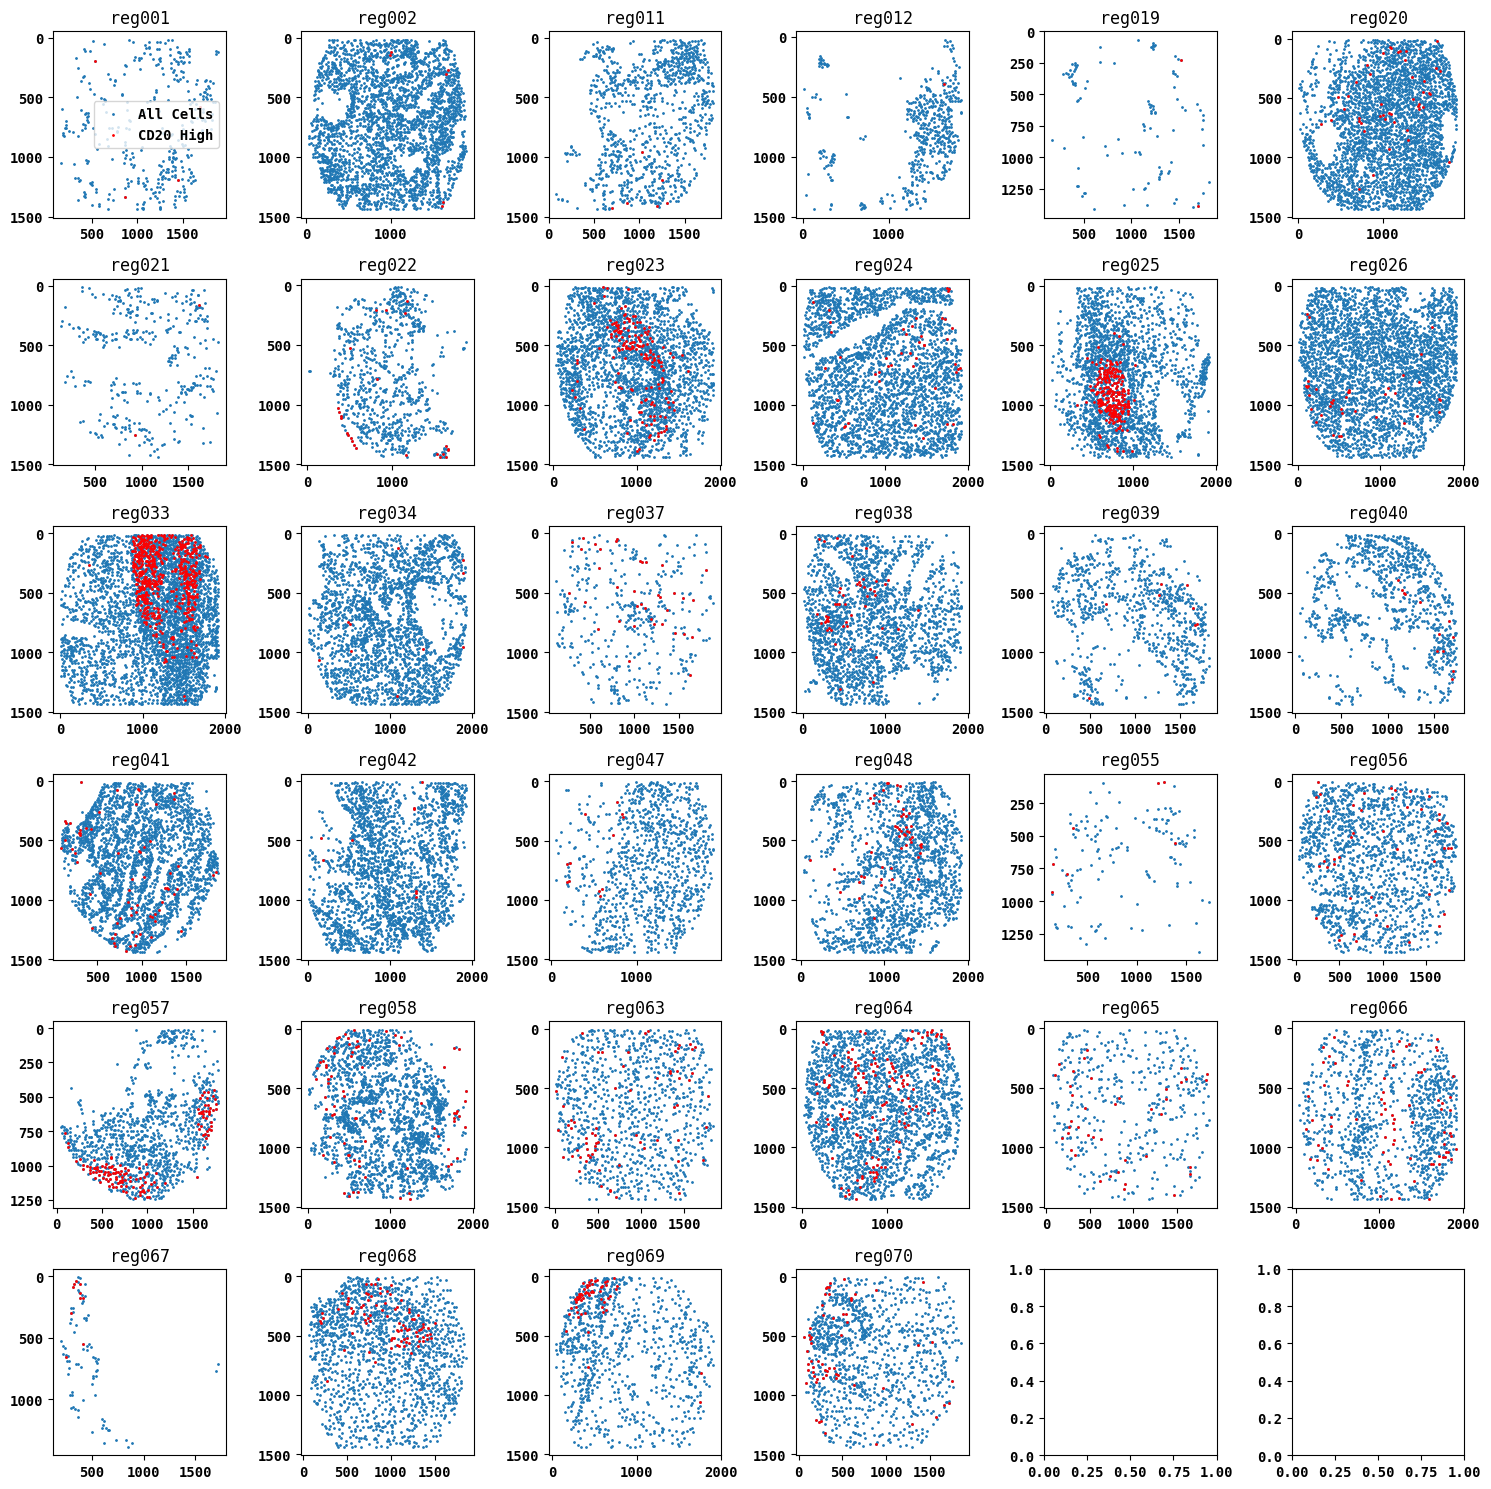

In [358]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Set up the grid layout: 4x4 grid plus 1 additional plot
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
axes = axes.flatten()  # Flatten to easily access each subplot

for i, region in enumerate(np.unique(df_final['Region'])):
    ax = axes[i]  # Get the correct axis for the current subplot
    
    # Assuming your dataframe is named df_final
    identifier = 'Region'  # or 'CellID' if you want to group by individual cells
    
    # Select the region or identifier you want to visualize
    selected_region = region  # Example identifier
    
    # Filter the dataframe for the selected region
    df_sub = df_final[df_final[identifier] == selected_region]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Columns to drop (excluding X, Y)
    columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'Z']
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Adaptive thresholding based on CD20 intensity after Z-score normalization
    cd20_normalized = df_sub['CD20']
    cd20_threshold = cd20_normalized.mean() + cd20_normalized.std()
    cd20_high = cd20_normalized > cd20_threshold
    
    # Separate CD20 high-intensity cells
    high_cells = df_sub[cd20_high]
    high_positions = positions[cd20_high]
    
    # Create a graph G using NetworkX for all cells
    G = nx.Graph()
    
    # Add nodes with feature data and positional information
    for index, row in df_sub.iterrows():
        node_id = row.name  # Use the index as node_id
        G.add_node(node_id, x=row.drop(['X', 'Y']).values.astype(float), pos=row[['X', 'Y']].values.astype(float))
    
    # Convert to torch geometric data
    data = torch_geometric.utils.from_networkx(G)
    data.x = torch.tensor([data['x'] for _, data in G.nodes(data=True)]).float()
    data.pos = torch.tensor([data['pos'] for _, data in G.nodes(data=True)]).float()
    
    # Visualization in the specified subplot
    ax.scatter(data.pos[:, 0], data.pos[:, 1], s=1, label='All Cells')
    ax.scatter(high_positions['X'], high_positions['Y'], s=1, color='red', label='CD20 High')
    ax.invert_yaxis()
    ax.set_title(selected_region)
    
    # Add legend only to the first plot to avoid clutter
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

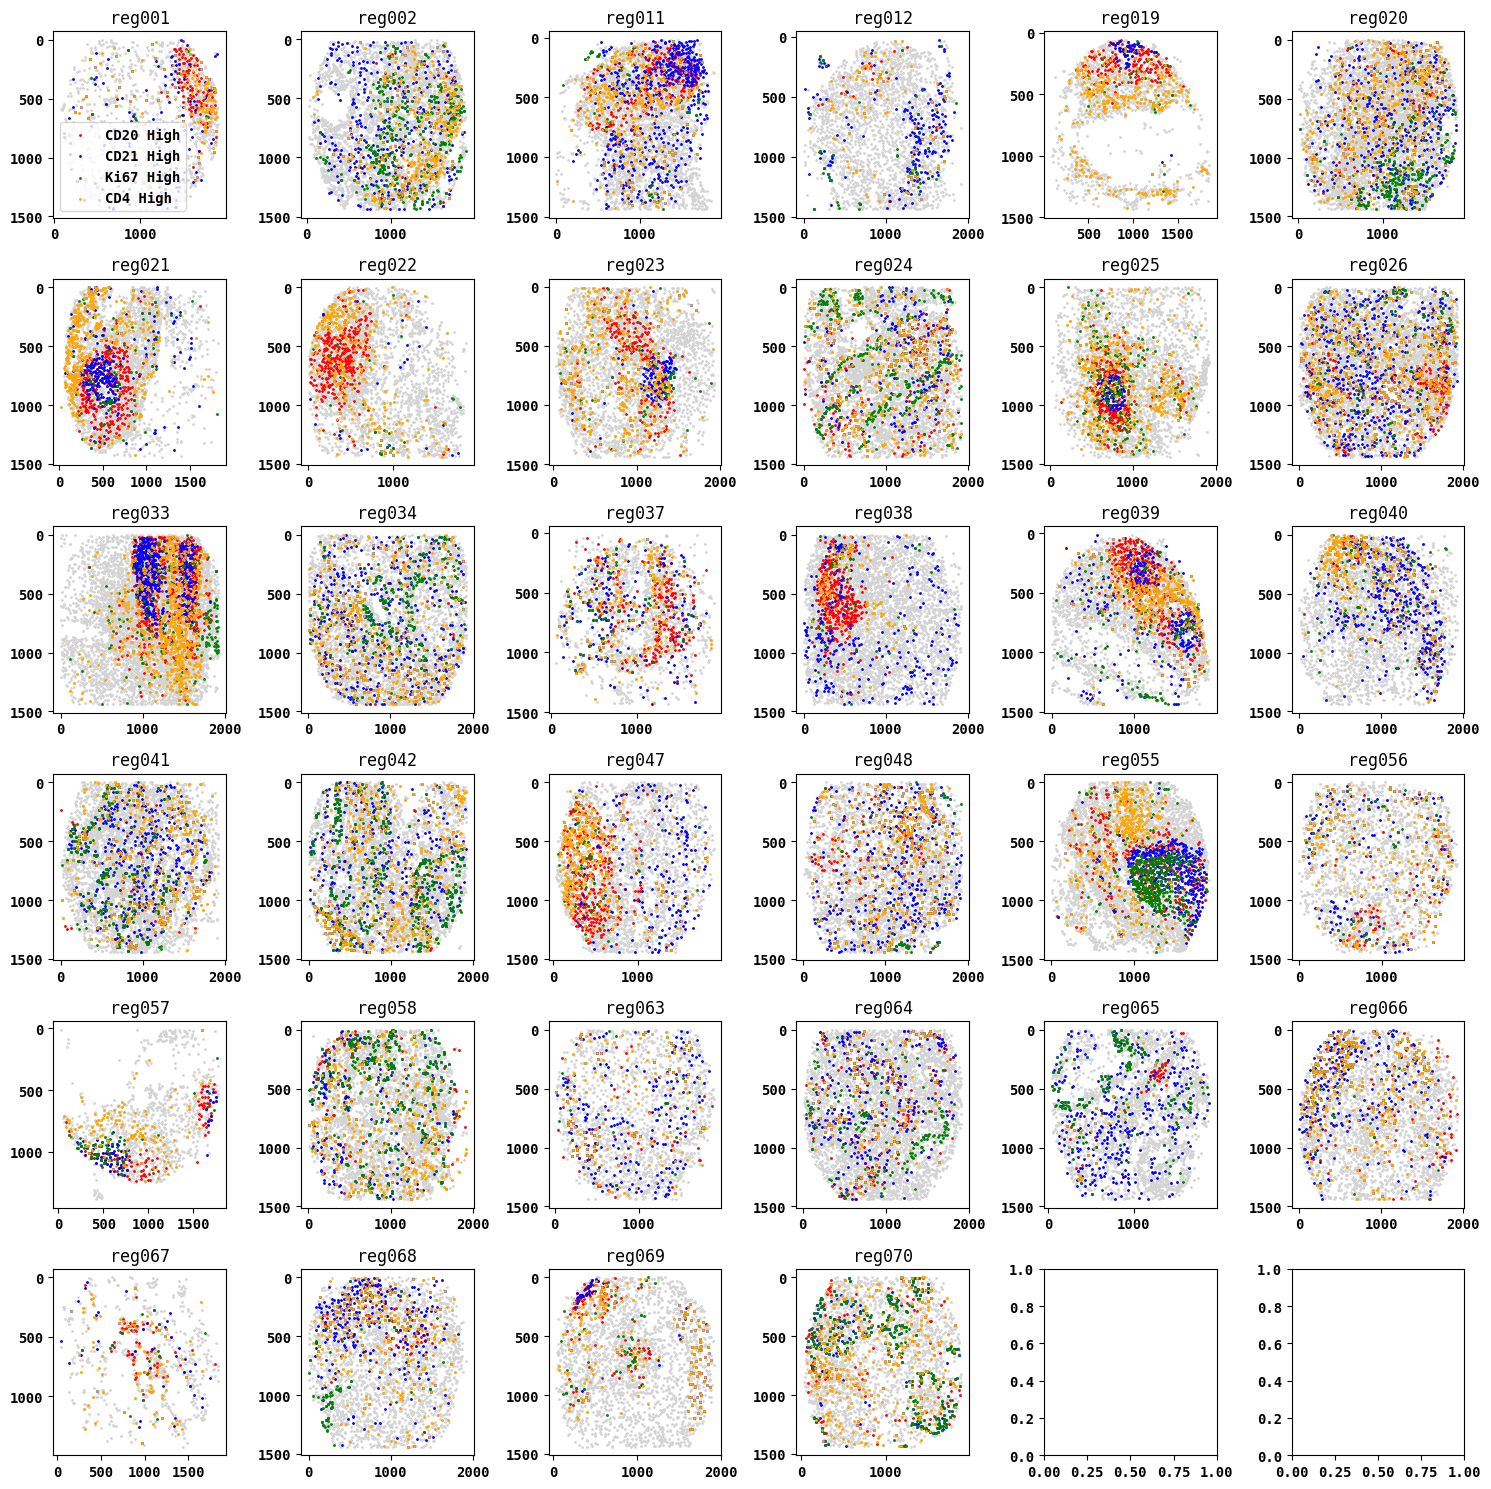

In [363]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Set up the grid layout: 4x4 grid for the first 16 plots
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
axes = axes.flatten()  # Flatten to easily access each subplot

# Define the markers to be highlighted and their corresponding colors
markers = {
    'CD20': 'red',
    'CD21': 'blue',
    'Ki67': 'green',
    'CD4': 'orange'
}

for i, region in enumerate(np.unique(df_final['Region'])):
    ax = axes[i]  # Get the correct axis for the current subplot
    
    # Select the region or identifier you want to visualize
    selected_region = region
    
    # Filter the dataframe for the selected region
    df_sub = df_final[df_final['Region'] == selected_region]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Columns to drop (excluding X, Y)
    columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'Z']
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Initialize the scatter plot for all cells
    ax.scatter(df_sub['X'], df_sub['Y'], s=1, color='lightgray')  # Plot all cells in light gray
    
    # Loop through each marker and highlight cells based on the threshold
    for marker, color in markers.items():
        if marker in df_sub.columns:
            marker_normalized = df_sub[marker]
            marker_threshold = marker_normalized.mean() + marker_normalized.std()
            marker_high = marker_normalized > marker_threshold
            high_positions = positions[marker_high]
            
            # Highlight the high-intensity cells for this marker
            ax.scatter(high_positions['X'], high_positions['Y'], s=1, color=color, label=f'{marker} High')

    # Invert y-axis for proper orientation
    ax.invert_yaxis()
    
    # Set title
    ax.set_title(selected_region)
    
    # Add legend only to the first plot to avoid clutter
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

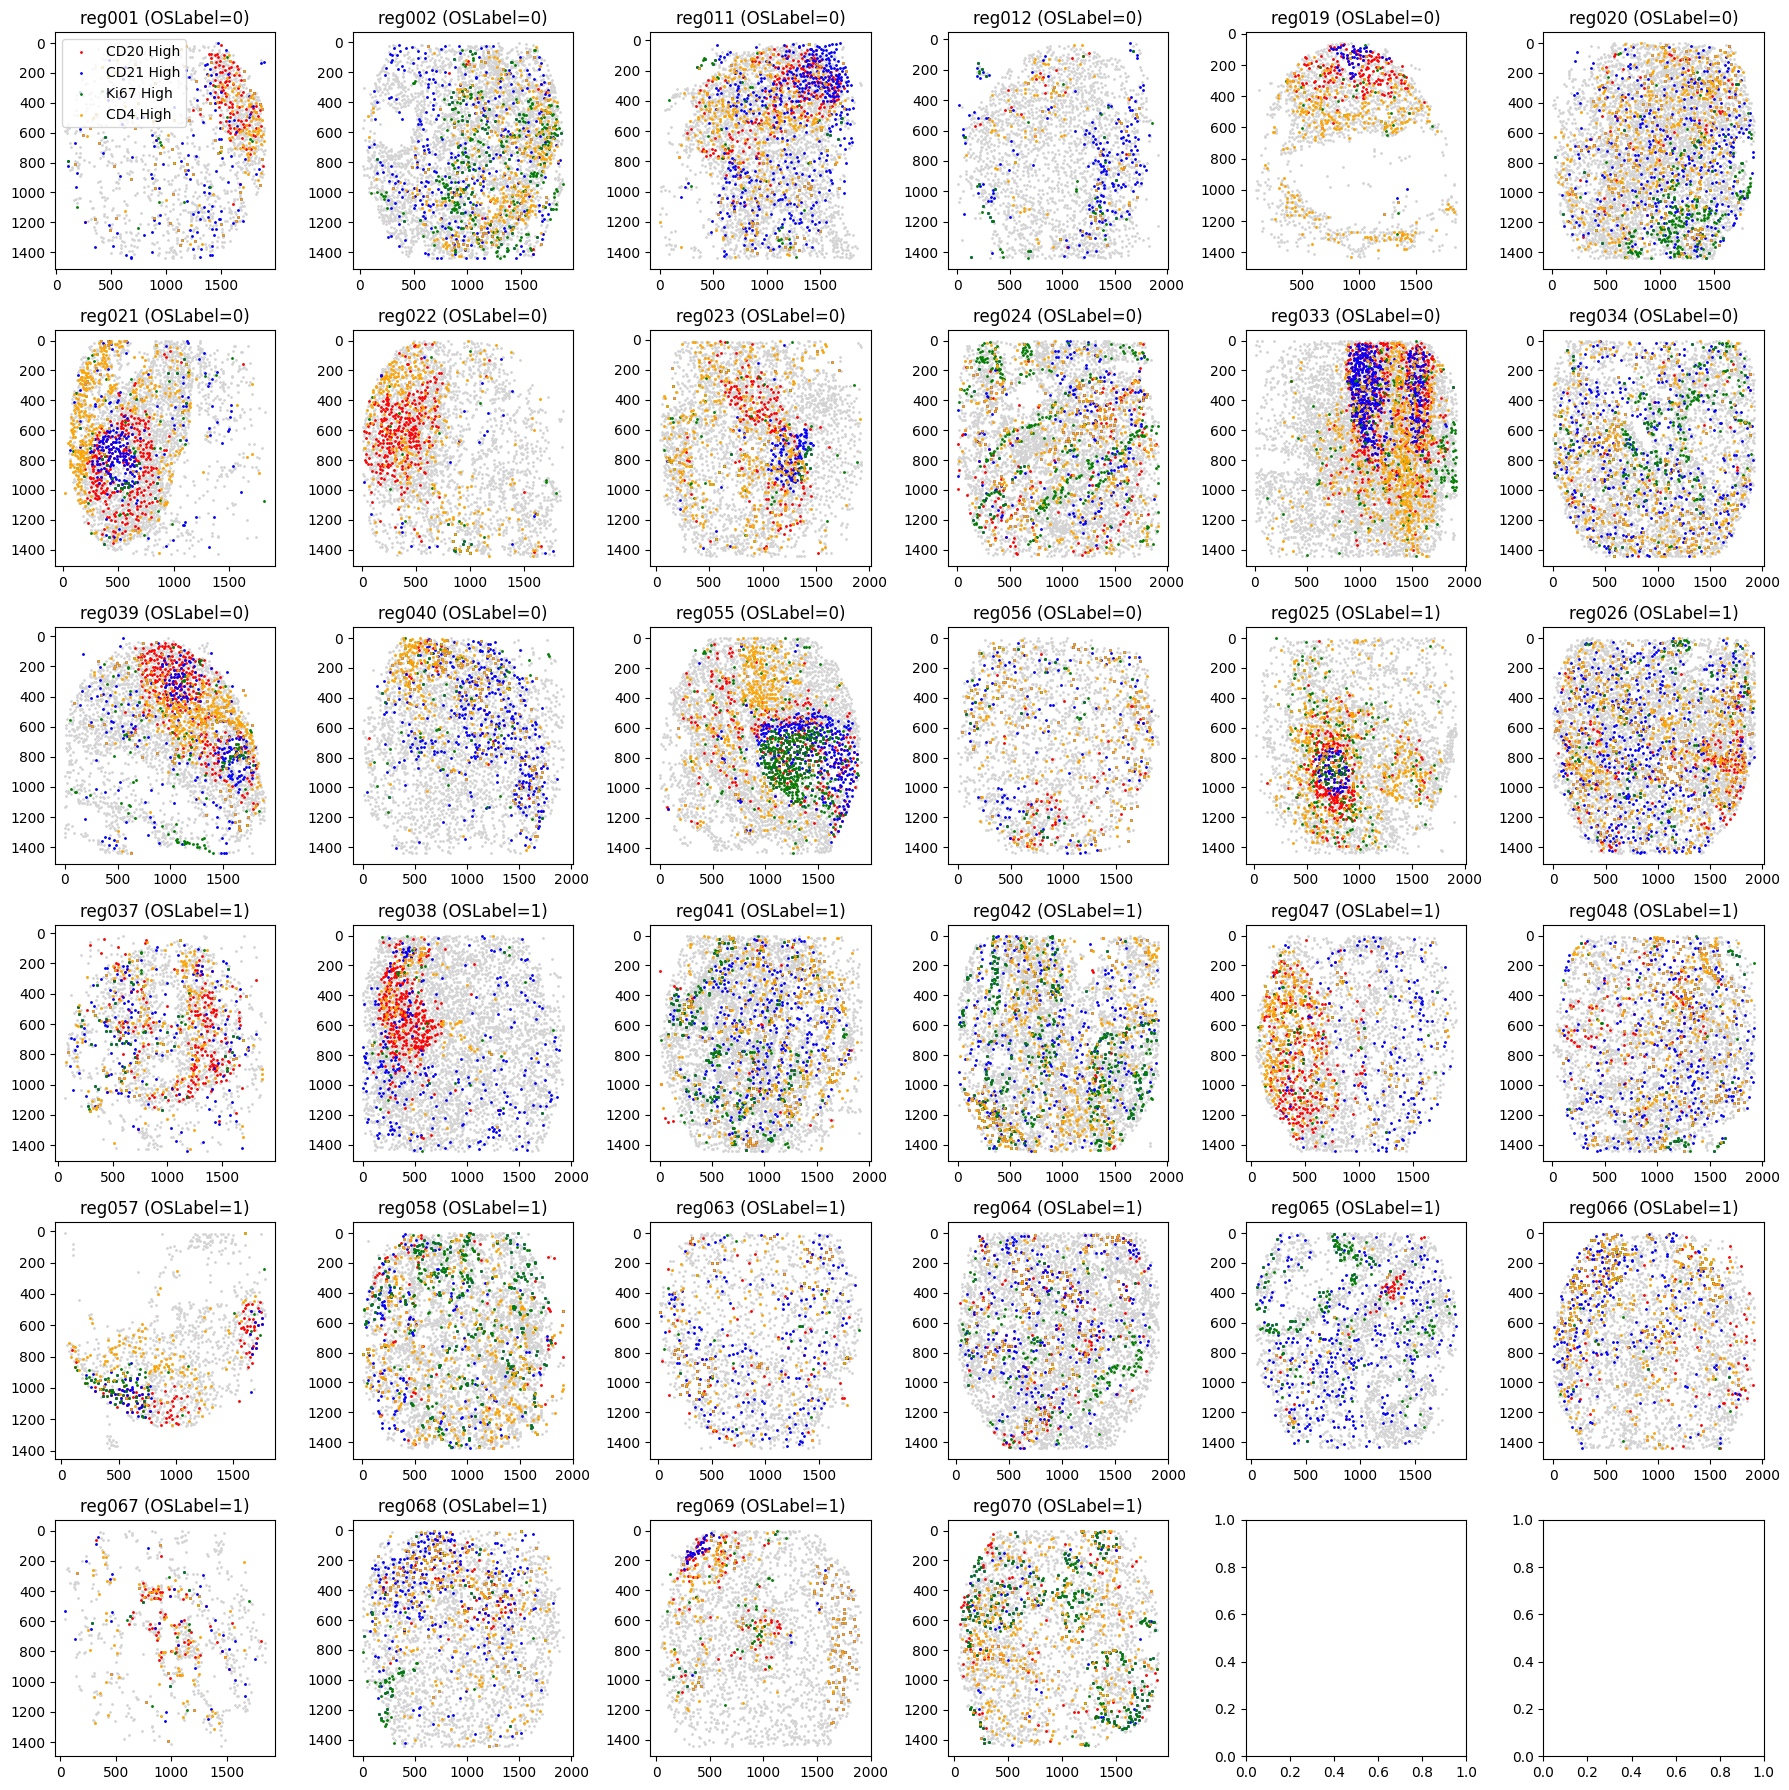

In [282]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Set up the grid layout: 6x6 grid for the plots
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
axes = axes.flatten()  # Flatten to easily access each subplot

# Define the markers to be highlighted and their corresponding colors
markers = {
    'CD20': 'red',
    'CD21': 'blue',
    'Ki67': 'green',
    'CD4': 'orange'
}

# Separate regions by OSLabel
regions_0 = df_final[df_final['OSLabel'] == 0]['Region'].unique()
regions_1 = df_final[df_final['OSLabel'] == 1]['Region'].unique()

# Plot for regions with OSLabel == 0
for i, region in enumerate(regions_0):
    ax = axes[i]  # Get the correct axis for the current subplot
    
    # Filter the dataframe for the selected region
    df_sub = df_final[df_final['Region'] == region]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Columns to drop (excluding X, Y)
    columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'OSLabel', 'Z']
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Initialize the scatter plot for all cells
    ax.scatter(df_sub['X'], df_sub['Y'], s=1, color='lightgray')  # Plot all cells in light gray
    
    # Loop through each marker and highlight cells based on the threshold
    for marker, color in markers.items():
        if marker in df_sub.columns:
            marker_normalized = df_sub[marker]
            marker_threshold = marker_normalized.mean() + marker_normalized.std()
            marker_high = marker_normalized > marker_threshold
            high_positions = positions[marker_high]
            
            # Highlight the high-intensity cells for this marker
            ax.scatter(high_positions['X'], high_positions['Y'], s=1, color=color, label=f'{marker} High')

    # Invert y-axis for proper orientation
    ax.invert_yaxis()
    
    # Set title
    ax.set_title(f'{region} (OSLabel=0)')
    
    # Add legend only to the first plot to avoid clutter
    if i == 0:
        ax.legend()

# Plot for regions with OSLabel == 1
for j, region in enumerate(regions_1):
    ax = axes[len(regions_0) + j]  # Continue with the next set of axes
    
    # Filter the dataframe for the selected region
    df_sub = df_final[df_final['Region'] == region]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Columns to drop (excluding X, Y)
    columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'OSLabel', 'Z']
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Initialize the scatter plot for all cells
    ax.scatter(df_sub['X'], df_sub['Y'], s=1, color='lightgray')  # Plot all cells in light gray
    
    # Loop through each marker and highlight cells based on the threshold
    for marker, color in markers.items():
        if marker in df_sub.columns:
            marker_normalized = df_sub[marker]
            marker_threshold = marker_normalized.mean() + marker_normalized.std()
            marker_high = marker_normalized > marker_threshold
            high_positions = positions[marker_high]
            
            # Highlight the high-intensity cells for this marker
            ax.scatter(high_positions['X'], high_positions['Y'], s=1, color=color, label=f'{marker} High')

    # Invert y-axis for proper orientation
    ax.invert_yaxis()
    
    # Set title
    ax.set_title(f'{region} (OSLabel=1)')
    
    # Add legend only to the first plot to avoid clutter
    if len(regions_0) == 0 and j == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [241]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from scipy.stats import zscore
from pathlib import Path

# Assuming your dataframe is named df_final
identifier = 'Region'  # or 'CellID' if you want to group by individual cells
status_column = 'OSLabel'  # This should be the column with 0 and 1 values

save_path = Path(process_path + '\\TLS_efe4')  # Update the path as needed
save_path.mkdir(parents=True, exist_ok=True)

data_names = []
paths = []

# Columns to drop (excluding X and Y)
columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'Z', status_column]

# Loop through each unique identifier
for id in df_final[identifier].unique():
    df_sub = df_final[df_final[identifier] == id]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Adaptive thresholding based on CD20 intensity after Z-score normalization
    cd20_normalized = df_sub['CD20']
    cd20_threshold = cd20_normalized.mean() + cd20_normalized.std()  # Example: Mean + 1 standard deviation
    cd20_high = cd20_normalized > cd20_threshold
    
    # Filter to keep only CD20 high-intensity cells
    df_high = df_sub[cd20_high]
    positions_high = positions[cd20_high]
    
    # Create a graph G using NetworkX for CD20 high-intensity cells
    G = nx.Graph()

    # Add nodes with feature data and positional information for CD20 high cells
    for index, row in df_high.iterrows():
        node_id = row.name  # Use the index as node_id
        G.add_node(node_id, x=row.drop(['X', 'Y']).values.astype(float), pos=row[['X', 'Y']].values.astype(float))

    # Optionally, add edges based on proximity or other criteria
    for node1, data1 in G.nodes(data=True):
        for node2, data2 in G.nodes(data=True):
            if node1 != node2:
                # Add edges based on a distance threshold using the positional information
                distance = np.linalg.norm(data1['pos'] - data2['pos'])
                if distance < 25:  # Example threshold
                    G.add_edge(node1, node2)

    # Convert to torch geometric data
    data = torch_geometric.utils.from_networkx(G)
    data.x = torch.tensor([data['x'] for _, data in G.nodes(data=True)]).float()
    data.pos = torch.tensor([data['pos'] for _, data in G.nodes(data=True)]).float()
    
    # Assign the label for the entire graph based on the status of the first row in the original subset
    graph_label = df_final[df_final[identifier] == id].iloc[0][status_column]
    data.y = torch.tensor([graph_label]).long()  # Graph-level label

    # Optionally, apply additional transforms like Polar if needed
    pos_transform = Polar()  # Uncomment if using a custom Polar transform
    data = pos_transform(data)
    
    # Save the graph data
    meta_id = f'{id}'
    path = save_path / f'{meta_id}.pt'
    torch.save(data, path)
    data_names.append(meta_id)
    paths.append(path)

# Save all information to a CSV
df_info = pd.DataFrame({'Dataset': data_names, 'Path': paths})
csv_path = save_path / 'info.csv'
df_info.to_csv(csv_path, index=False)

In [285]:
##combine all markers

In [331]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from scipy.stats import zscore
from pathlib import Path

# Assuming your dataframe is named df_final
identifier = 'Region'  # or 'CellID' if you want to group by individual cells
status_column = 'OSLabel'  # This should be the column with 0 and 1 values

save_path = Path(process_path + '\\TLS_efe8')  # Update the path as needed
save_path.mkdir(parents=True, exist_ok=True)

data_names = []
paths = []

# Columns to drop (excluding X and Y)
columns_to_drop = ['CellID', 'FileName', 'Region', 'Groups', 'Patients', 'OS', 'Z', status_column]

# Define the markers
markers = ['CD20', 'CD21', 'Ki67', 'CD4']

# Loop through each unique identifier
for id in df_final[identifier].unique():
    df_sub = df_final[df_final[identifier] == id]
    
    # Retain positional columns X and Y
    positions = df_sub[['X', 'Y']].copy()
    
    # Drop the specified columns
    df_sub = df_sub.drop(columns=columns_to_drop)
    
    # Ensure the feature columns are numerical and handle any NaNs
    df_sub = df_sub.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Apply Z-score normalization (excluding positional data)
    df_sub = df_sub.drop(columns=['X', 'Y'])  # Temporarily drop positional columns
    df_sub = df_sub.apply(zscore, axis=0)
    
    # Re-add positional data after normalization
    df_sub[['X', 'Y']] = positions
    
    # Combine conditions for all markers to identify high-intensity cells
    high_intensity_cells = np.zeros(len(df_sub), dtype=bool)
    for marker in markers:
        if marker in df_sub.columns:
            marker_normalized = df_sub[marker]
            marker_threshold = marker_normalized.mean() + marker_normalized.std()  # Example: Mean + 1 standard deviation
            high_intensity_cells |= (marker_normalized > marker_threshold)  # Logical OR to combine conditions

    # Filter to keep only high-intensity cells for any marker
    df_high = df_sub[high_intensity_cells]
    positions_high = positions[high_intensity_cells]
    
    # Create a graph G using NetworkX for high-intensity cells
    G = nx.Graph()

    # Add nodes with feature data and positional information for high-intensity cells
    for index, row in df_high.iterrows():
        node_id = row.name  # Use the index as node_id
        G.add_node(node_id, x=row.drop(['X', 'Y']).values.astype(float), pos=row[['X', 'Y']].values.astype(float))

    # Optionally, add edges based on proximity or other criteria
    for node1, data1 in G.nodes(data=True):
        for node2, data2 in G.nodes(data=True):
            if node1 != node2:
                # Add edges based on a distance threshold using the positional information
                distance = np.linalg.norm(data1['pos'] - data2['pos'])
                if distance < 10:  # Example threshold
                    G.add_edge(node1, node2)

    # Convert to torch geometric data
    data = torch_geometric.utils.from_networkx(G)
    data.x = torch.tensor([data['x'] for _, data in G.nodes(data=True)]).float()
    data.pos = torch.tensor([data['pos'] for _, data in G.nodes(data=True)]).float()
    
    # Assign the label for the entire graph based on the status of the first row in the original subset
    graph_label = df_final[df_final[identifier] == id].iloc[0][status_column]
    data.y = torch.tensor([graph_label]).long()  # Graph-level label

    # Optionally, apply additional transforms like Polar if needed
    pos_transform = Polar()  # Uncomment if using a custom Polar transform
    data = pos_transform(data)
    
    # Save the graph data
    meta_id = f'{id}'
    path = save_path / f'{meta_id}.pt'
    torch.save(data, path)
    data_names.append(meta_id)
    paths.append(path)

# Save all information to a CSV
df_info = pd.DataFrame({'Dataset': data_names, 'Path': paths})
csv_path = save_path / 'info.csv'
df_info.to_csv(csv_path, index=False)

RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [339]:
#tls data stat plots

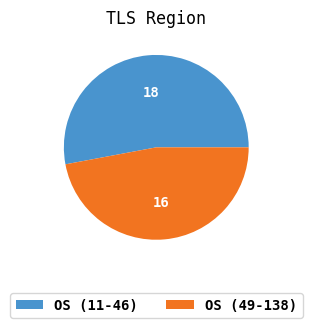

In [420]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the font properties
font = {'family': 'monospace',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)

# Group by 'Region' and 'OSLabel', and count the occurrences
df_pie = df_final.groupby(['Region', 'OSLabel']).size().unstack().fillna(0)

# Determine which OSLabel is dominant in each region
df_pie['DominantLabel'] = df_pie.idxmax(axis=1)

# Count the number of regions dominated by each OSLabel
dominant_counts = df_pie['DominantLabel'].value_counts()

# Define the data and labels
data = dominant_counts.values
labels = ['OS (11-46)', 'OS (49-138)']

# Define the Seaborn color palette to use
colors = ['#4994CE', '#F27420']

# Function to show absolute values on the pie chart
def absolute_value(val):
    a = np.round(val / 100. * data.sum(), 0).astype(int)
    return a

# Create the pie chart
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, labels=labels, colors=colors, autopct=absolute_value, textprops=dict(color="w"))

# Move the legend to below the chart
ax.legend(wedges, labels,
          loc="upper center",
          bbox_to_anchor=(0.5, -0.1),  # Adjust this to control legend position
          ncol=2)  # This allows the legend items to be side by side

plt.title('TLS Region')
plt.show()

In [ ]:
###load

In [336]:
graph_data = torch.load(process_path+'\\TLS_efe6\\reg021.pt')
#graph_data = torch.load(process_path+'\\Breast\\pt\\MB-0000_527.pt')

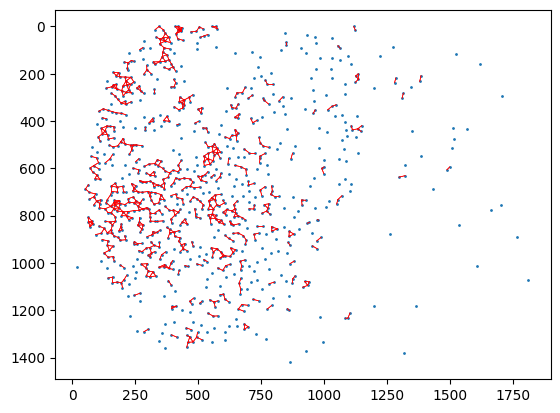

In [338]:
plt.scatter(graph_data.pos[:,0], graph_data.pos[:,1],s=1)

for edge in graph_data.edge_index.t().tolist():
    node1 = edge[0]
    node2 = edge[1]
    x = [graph_data.pos[node1, 0], graph_data.pos[node2, 0]]
    y = [graph_data.pos[node1, 1], graph_data.pos[node2, 1]]
    plt.plot(x, y, color='red', linewidth=0.5)
    
plt.gca().invert_yaxis()

In [70]:
total_cells = 0
total_os = 0
for file in os.listdir(process_path+'\\TLS_efe6')[1:]:
    graph_data = torch.load(process_path+'\\TLS_efe6\\'+file)
    total_cells += graph_data.num_nodes
    total_os += int(graph_data.y)
print(total_cells)
print(total_os)

28129
18


In [364]:
# load raw images

In [101]:
tif = io.imread('Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline\\Data\\Datasets\\tls_colon_codex\\reg001_X01_Y01.tif')

In [102]:
tif.shape

(2, 17, 1440, 1920, 4)

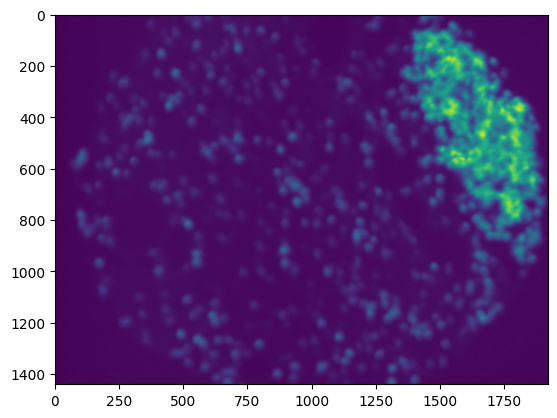

In [103]:
plt.imshow(tif[0,5,:,:,0])

In [365]:
####

In [1]:
import tifffile as tiff
img_dir = 'Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline\\Data\\Datasets\\tls_colon_codex\\'

# Open the TIFF file
with tiff.TiffFile(img_dir+'reg048_X01_Y01.tif') as tif:
    # Access the first series
    series = tif.series[0]
    
    # Get the shape of the entire dataset
    data_shape = series.shape
    print(f"Shape of the data: {data_shape}")

    # Alternatively, if you want to see the shapes of individual pages
    print(f"Number of pages: {len(series.pages)}")
    page_shapes = [page.shape for page in series.pages]
    print(f"Shape of individual pages: {page_shapes[:5]} ...")  # Print first 5 for brevity


Shape of the data: (23, 17, 4, 1440, 1920)
Number of pages: 1
Shape of individual pages: [(1440, 1920)] ...


In [48]:
import tifffile as tiff
# Open the TIFF file and load the data
with tiff.TiffFile(img_dir+'reg047_X01_Y01.tif') as tif:
    # Access the first series and read the full array
    data = tif.series[0].asarray()

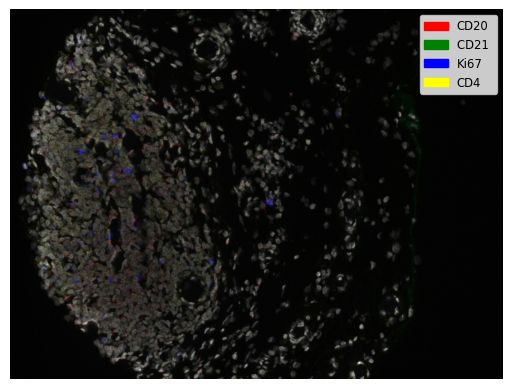

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

channel = 7
# Normalize the channels if needed
dapi = data[7, channel, 0, :, :]
cd20 = data[7, channel, 2, :, :]
cd21 = data[5, channel, 3, :, :]
ki67 = data[4, channel, 3, :, :]
cd4 = data[5, channel, 2, :, :]

# Normalize to [0, 1] for proper display
dapi = (dapi - np.min(dapi)) / (np.max(dapi) - np.min(dapi))
cd20 = (cd20 - np.min(cd20)) / (np.max(cd20) - np.min(cd20))
cd21 = (cd21 - np.min(cd21)) / (np.max(cd21) - np.min(cd21))
ki67 = (ki67 - np.min(ki67)) / (np.max(ki67) - np.min(ki67))
cd4 = (cd4 - np.min(cd4)) / (np.max(cd4) - np.min(cd4))

# Create an RGB image by combining different channels
rgb_image = np.stack([cd20 + dapi + cd4, cd21 + dapi + cd4, ki67 + dapi], axis=-1)

# Clip values to ensure they stay within [0, 1] after adding DAPI
rgb_image = np.clip(rgb_image, 0, 1)

# Display the combined image
plt.imshow(rgb_image)
plt.axis('off')

# Create custom legend handles
legend_elements = [
    Patch(facecolor='red', edgecolor='r', label='CD20'),
    Patch(facecolor='green', edgecolor='g', label='CD21 '),
    Patch(facecolor='blue', edgecolor='b', label='Ki67'),
    Patch(facecolor='yellow', edgecolor='yellow', label='CD4')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize='small')
plt.savefig(f'Y:\\coskun-lab\\Efe and Nishkala\\SnowflakePipeline\\11_snowflakes\\notebooks\\figures\\reg047_overlay.jpg', dpi=1200, bbox_inches='tight', pad_inches=0)
plt.show()